In [3]:
install.packages("caret")
install.packages("MLmetrics")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




In [4]:
install.packages("xgboost")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(tidyverse)
library(caret)
library(nnet)
library(MLmetrics)
library(dplyr)
library(glmnet)
library(e1071)
library(pROC)
library(xgboost)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MLmetrics’


The following objects are masked from ‘package:caret’:

    MAE, RMSE


The following object is masked from ‘package:base’:

    Recall


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [6]:
df <- read.csv("/df_grouping2.csv")

In [7]:
df$disp_group <- as.factor(df$disp_group)
y <- as.factor(df$disp_group)
X <- df %>% select(-disp_group) %>% as.matrix()

In [8]:
train_index <- createDataPartition(y, p = 0.8, list = FALSE)
X_train <- X[train_index, ]
X_test  <- X[-train_index, ]
y_train <- y[train_index]
y_test  <- y[-train_index]

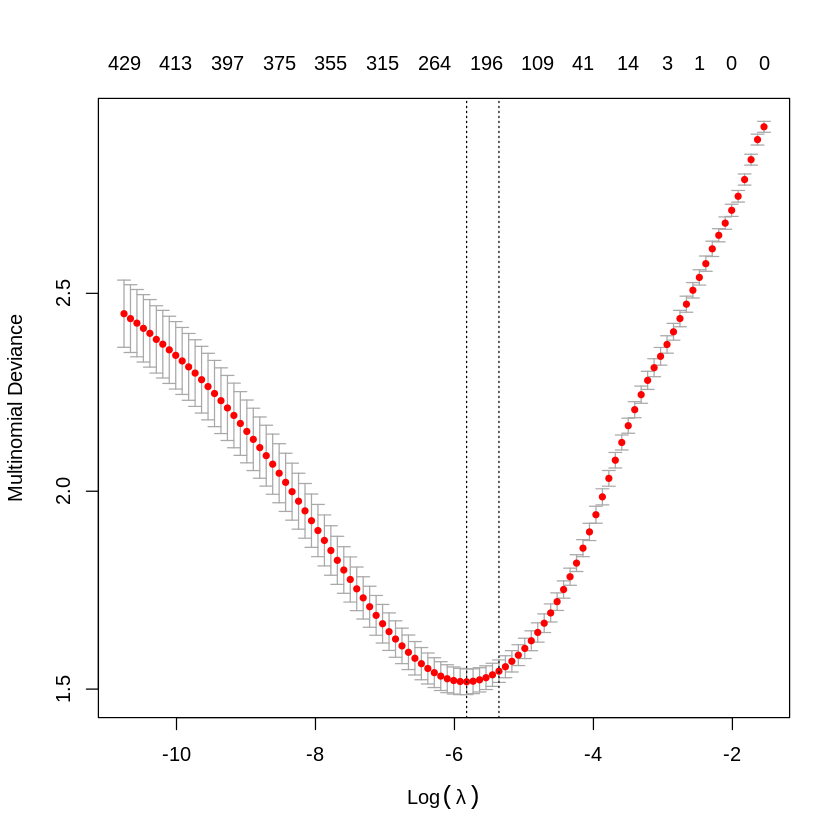

In [58]:
set.seed(123)
cv_lasso <- cv.glmnet(X_train, y_train, family = "multinomial", alpha = 1, nfolds = 5)

plot(cv_lasso)

In [59]:
lasso_pred_class <- predict(cv_lasso, newx = X_test, type = "class")

conf_mat <- confusionMatrix(as.factor(lasso_pred_class), as.factor(y_test))
print(conf_mat)

Confusion Matrix and Statistics

           Reference
Prediction  admit discharge left returned transfer
  admit       380        28   26       31       42
  discharge    18       155   21       19        3
  left         14        15   67        4       12
  returned     40        41   32      354       12
  transfer      8         1    3        2       21

Overall Statistics
                                          
               Accuracy : 0.7242          
                 95% CI : (0.6996, 0.7479)
    No Information Rate : 0.341           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6194          
                                          
 Mcnemar's Test P-Value : 6.164e-12       

Statistics by Class:

                     Class: admit Class: discharge Class: left Class: returned
Sensitivity                0.8261           0.6458     0.44966          0.8634
Specificity                0.8571           0.9450  

In [60]:
lasso_pred_prob <- predict(cv_lasso, newx = X_test, type = "response")
lasso_pred_prob <- lasso_pred_prob[,,1]

In [61]:
# Accuracy
accuracy_logit <- conf_mat$overall['Accuracy']
cat("Accuracy:", round(accuracy_logit, 4), "\n")

# Precision, Recall, F1 (macro 平均)
precision_logit <- mean(conf_mat$byClass[, "Precision"], na.rm = TRUE)
recall_logit <- mean(conf_mat$byClass[, "Recall"], na.rm = TRUE)
f1_logit <- mean(conf_mat$byClass[, "F1"], na.rm = TRUE)

cat("Precision (macro):", round(precision_logit, 4), "\n")
cat("Recall (macro):", round(recall_logit, 4), "\n")
cat("F1 Score (macro):", round(f1_logit, 4), "\n")

# AUC (multiclass)
multi_roc_logit <- multiclass.roc(y_test, lasso_pred_prob)
auc_logit <- multi_roc_logit$auc
cat("AUC:", round(auc_logit, 4), "\n")

Accuracy: 0.7242 
Precision (macro): 0.6809 
Recall (macro): 0.6037 
F1 Score (macro): 0.6223 
AUC: 0.8726 


In [62]:
levels_y <- levels(y_train)
roc_list <- list()

for (i in seq_along(levels_y)) {
  current_class <- levels_y[i]

  response_binary <- ifelse(y_test == current_class, 1, 0)

  predictor_prob <- lasso_pred_prob[, current_class]

  roc_obj <- roc(response = response_binary, predictor = predictor_prob)

  roc_list[[current_class]] <- roc_obj
}

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC for admit: 0.9204 
AUC for discharge: 0.9168 
AUC for left: 0.8493 
AUC for returned: 0.9363 
AUC for transfer: 0.8175 


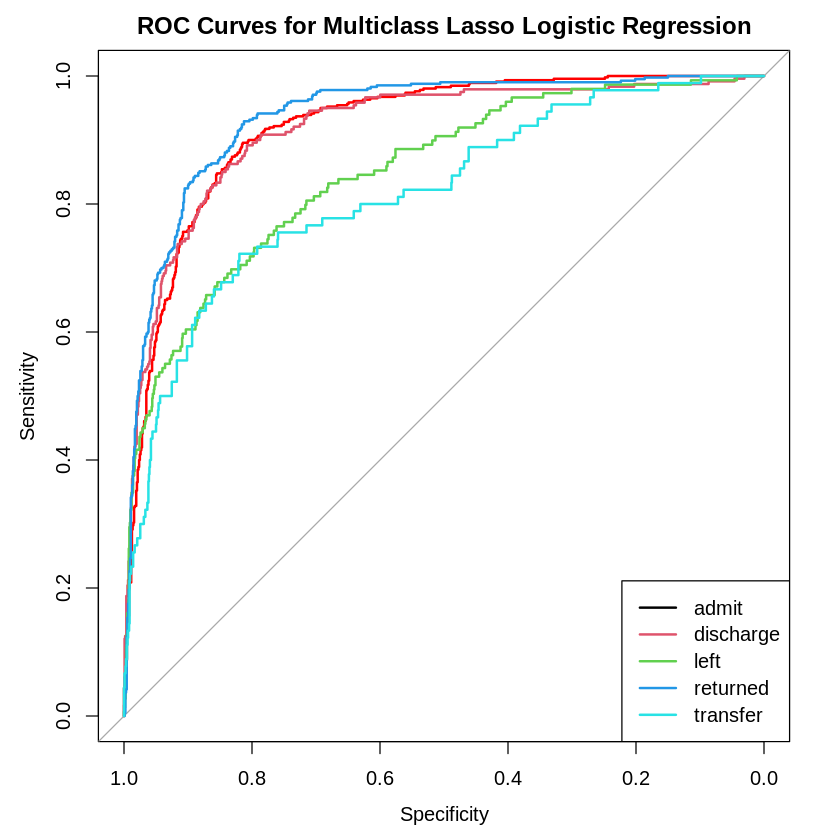

In [63]:
plot(roc_list[[1]], col = "red", main = "ROC Curves for Multiclass Lasso Logistic Regression", lwd = 2)

for (i in 2:length(roc_list)) {
  plot(roc_list[[i]], col = i, add = TRUE, lwd = 2)
}

legend("bottomright", legend = names(roc_list), col = 1:length(roc_list), lwd = 2)

for (class_name in names(roc_list)) {
  cat(paste0("AUC for ", class_name, ": ", round(auc(roc_list[[class_name]]), 4)), "\n")
}

In [41]:
df <- read.csv("/df_grouping2.csv")
head(df)

,cc_Sx_eyes_ears,cc_Sx_neuro,cc_Therapy_specific,cc_Sx_general,cc_Sx_psych,cc_Poisoning,cc_Sx_skin_nails_hair,cc_Injury_cause_status,cc_Test_results,cc_Exam_special,⋯,hospcode_173,hospcode_159,hospcode_155,hospcode_187,hospcode_163,hospcode_180,hospcode_151,hospcode_177,hospcode_164,disp_group
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,admit
2,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,discharge
3,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,left
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,transfer
5,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,admit
6,0,0,1,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,admit


In [42]:
y <- as.factor(df$disp_group)

In [43]:
set.seed(123)
train_index <- createDataPartition(y, p = 0.8, list = FALSE)
X_train <- X[train_index, ]
X_test  <- X[-train_index, ]
y_train <- y[train_index]
y_test  <- y[-train_index]

In [45]:
svm_model <- svm(x = X_train, y = y_train, kernel = "radial", probability = TRUE)

y_pred_svm <- predict(svm_model, X_test)

confusionMatrix(y_pred_svm, y_test)

Warning message in svm.default(x = X_train, y = y_train, kernel = "radial", probability = TRUE):
“Variable(s) ‘CAUSE1_W139’ and ‘CAUSE1_Y921’ and ‘E279_yes’ and ‘L989_no’ and ‘CAUSE1_V426’ and ‘CAUSE1_V496’ and ‘CAUSE1_V866’ and ‘CAUSE1_X30X’ and ‘CAUSE2_W009’ and ‘CAUSE2_W268’ and ‘B349_yes’ and ‘S060_yes’ and ‘CAUSE1_V799’ and ‘CAUSE1_X18X’ and ‘CAUSE1_V405’ and ‘CAUSE1_V899’ and ‘CAUSE2_W501’ and ‘CAUSE2_Y846’ and ‘R098_yes’ and ‘CAUSE1_W04X’ and ‘CAUSE1_W552’ and ‘CAUSE1_X781’ and ‘CAUSE3_Y070’ and ‘hospcode_176’ constant. Cannot scale data.”


Confusion Matrix and Statistics

           Reference
Prediction  admit discharge left returned transfer
  admit       425       137  115      200       77
  discharge     8        57    7        7        1
  left          1         1    3        2        2
  returned     26        45   23      201       10
  transfer      0         0    1        0        0

Overall Statistics
                                          
               Accuracy : 0.5085          
                 95% CI : (0.4815, 0.5355)
    No Information Rate : 0.341           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.276           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: admit Class: discharge Class: left Class: returned
Sensitivity                0.9239          0.23750    0.020134          0.4902
Specificity                0.4049          0.97926  

In [29]:
y_pred_svm <- predict(svm_model, X_test)

confusion <- confusionMatrix(y_pred_svm, y_test)

confusion

Confusion Matrix and Statistics

           Reference
Prediction  admit discharge left returned transfer
  admit       425       137  115      200       77
  discharge     8        57    7        7        1
  left          1         1    3        2        2
  returned     26        45   23      201       10
  transfer      0         0    1        0        0

Overall Statistics
                                          
               Accuracy : 0.5085          
                 95% CI : (0.4815, 0.5355)
    No Information Rate : 0.341           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.276           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: admit Class: discharge Class: left Class: returned
Sensitivity                0.9239          0.23750    0.020134          0.4902
Specificity                0.4049          0.97926  

In [20]:
install.packages("yardstick")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [33]:
library(yardstick)


Attaching package: ‘yardstick’


The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:readr’:

    spec




In [46]:
svm_eval_df <- data.frame(
  truth = as.factor(y_test),
  prediction = as.factor(y_pred_svm)
)

# Precision (macro)
precision_macro <- svm_eval_df %>%
  yardstick::precision(truth = truth, estimate = prediction, estimator = "macro")
print(precision_macro)

# Recall (macro)
recall_macro <- svm_eval_df %>%
  yardstick::recall(truth = truth, estimate = prediction, estimator = "macro")
print(recall_macro)

# F1 Score (macro)
f1_macro <- svm_eval_df %>%
  yardstick::f_meas(truth = truth, estimate = prediction, estimator = "macro")
print(f1_macro)

# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision macro          0.430
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  macro          0.334
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 f_meas  macro          0.312


In [47]:
svm_pred_prob_test <- predict(svm_model, X_test, type = "prob")
svm_pred_class_test <- predict(svm_model, X_test)

In [48]:
conf_mat_test <- confusionMatrix(svm_pred_class_test, y_test)
print(conf_mat_test)

Confusion Matrix and Statistics

           Reference
Prediction  admit discharge left returned transfer
  admit       425       137  115      200       77
  discharge     8        57    7        7        1
  left          1         1    3        2        2
  returned     26        45   23      201       10
  transfer      0         0    1        0        0

Overall Statistics
                                          
               Accuracy : 0.5085          
                 95% CI : (0.4815, 0.5355)
    No Information Rate : 0.341           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.276           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: admit Class: discharge Class: left Class: returned
Sensitivity                0.9239          0.23750    0.020134          0.4902
Specificity                0.4049          0.97926  

In [50]:
results_df <- data.frame(
  truth = factor(y_train),
  prediction = factor(svm_pred_class)
)

# Precision
precision_macro <- yardstick::precision(results_df, truth = truth, estimate = prediction, estimator = "macro")
cat("Precision (Macro Avg):", round(precision_macro$.estimate, 4), "\n")

# Recall
recall_macro <- yardstick::recall(results_df, truth = truth, estimate = prediction, estimator = "macro")
cat("Recall (Macro Avg):", round(recall_macro$.estimate, 4), "\n")

# F1 Score
f1_macro <- yardstick::f_meas(results_df, truth = truth, estimate = prediction, estimator = "macro")
cat("F1 Score (Macro Avg):", round(f1_macro$.estimate, 4), "\n")

Precision (Macro Avg): 0.599 
Recall (Macro Avg): 0.5764 
F1 Score (Macro Avg): 0.5225 


In [51]:
library(pROC)

In [52]:
# multiclass ROC
multi_roc <- multiclass.roc(y_train, svm_pred_prob)

# AUC
auc_value <- multi_roc$auc
cat("Multiclass AUC:", auc_value, "\n")

Multiclass AUC: 0.8981898 


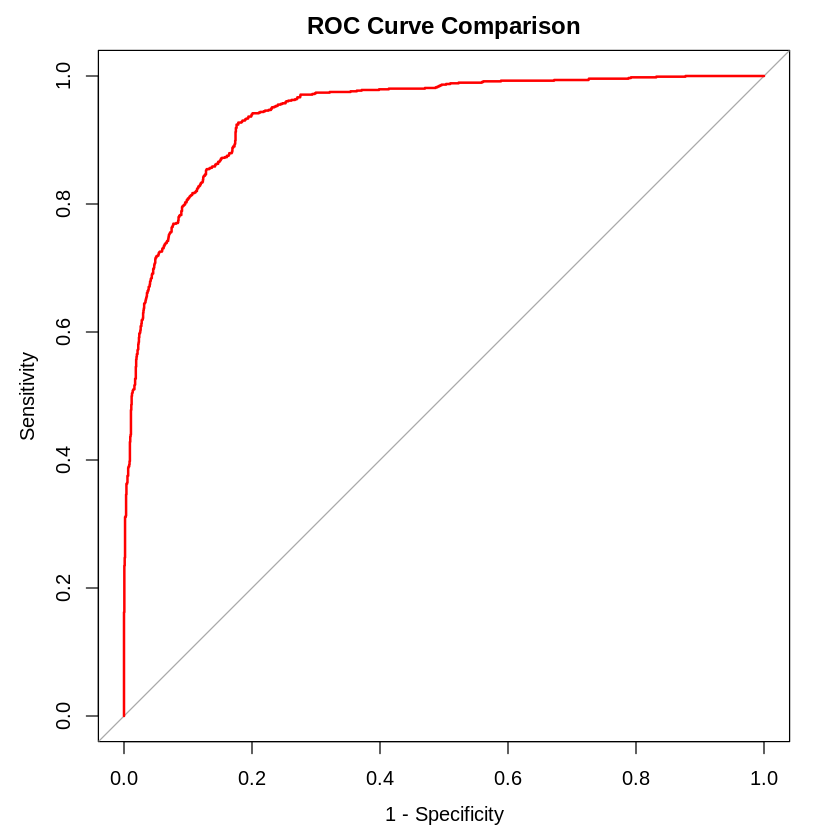

In [53]:
svm_roc_list <- multi_roc$rocs

plot.roc(svm_roc_list[[1]][[1]], col = "red", lwd = 2,
         main = "ROC Curve Comparison", legacy.axes = TRUE)


In [54]:
levels_y <- levels(y_train)
roc_list <- list()

for (i in seq_along(levels_y)) {
  current_class <- levels_y[i]

  response_binary <- ifelse(y_test == current_class, 1, 0)

  predictor_prob <- lasso_pred_prob[, current_class]

  roc_obj <- roc(response = response_binary, predictor = predictor_prob)

  roc_list[[current_class]] <- roc_obj
}

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



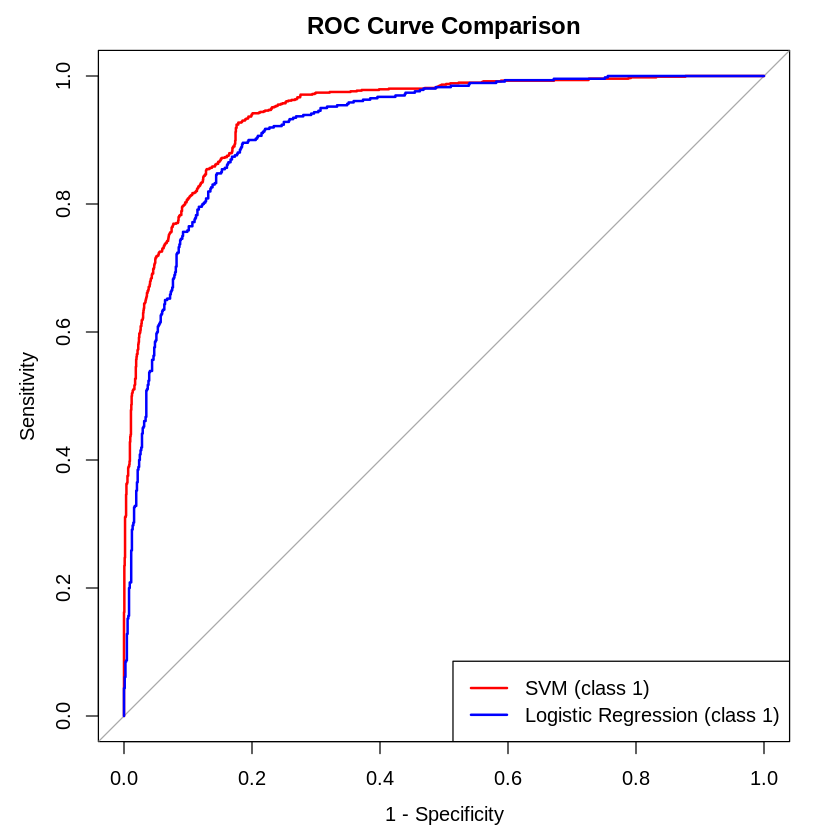

In [64]:
# SVM
plot.roc(svm_roc_list[[1]][[1]], col = "red", lwd = 2,
         main = "ROC Curve Comparison", legacy.axes = TRUE)

# Logistic Regression (LASSO)
plot.roc(roc_list[[1]], col = "blue", lwd = 2, add = TRUE)

legend("bottomright",
       legend = c("SVM (class 1)", "Logistic Regression (class 1)"),
       col = c("red", "blue"),
       lwd = 2)

In [65]:
X_train_mat <- as.matrix(X_train)
X_test_mat <- as.matrix(X_test)
y_train_numeric <- as.numeric(y_train) - 1
y_test_numeric <- as.numeric(y_test) - 1

set.seed(123)
cv_model <- xgb.cv(
  data = X_train_mat,
  label = y_train_numeric,
  nrounds = 100,
  nfold = 5,
  objective = "multi:softprob",
  num_class = length(unique(y_train)),
  metrics = "mlogloss",
  early_stopping_rounds = 10,
  verbose = 1
)

best_nrounds <- cv_model$best_iteration
print(paste("Best nrounds:", best_nrounds))

[1]	train-mlogloss:1.306989+0.004398	test-mlogloss:1.347207+0.011675 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

[2]	train-mlogloss:1.129164+0.006609	test-mlogloss:1.200808+0.017541 
[3]	train-mlogloss:1.003274+0.009059	test-mlogloss:1.103565+0.021306 
[4]	train-mlogloss:0.909223+0.007384	test-mlogloss:1.034004+0.026330 
[5]	train-mlogloss:0.833771+0.009864	test-mlogloss:0.982973+0.030877 
[6]	train-mlogloss:0.769918+0.010656	test-mlogloss:0.943717+0.034627 
[7]	train-mlogloss:0.719478+0.012144	test-mlogloss:0.912909+0.033837 
[8]	train-mlogloss:0.676512+0.012026	test-mlogloss:0.889359+0.037681 
[9]	train-mlogloss:0.641520+0.011047	test-mlogloss:0.869033+0.038904 
[10]	train-mlogloss:0.609550+0.012467	test-mlogloss:0.855396+0.039439 
[11]	train-mlogloss:0.581030+0.012275	test-mlogloss:0.842794+0.041418 
[12]	train-mlogloss:0.556068+0.011589	test-mlogloss:0.833070+0.042171 
[13]	train-mloglo

In [66]:
final_model <- xgboost(
  data = X_train_mat,
  label = y_train_numeric,
  nrounds = best_nrounds,
  objective = "multi:softprob",
  num_class = length(unique(y_train)),
  verbose = 1
)

[1]	train-mlogloss:1.311679 
[2]	train-mlogloss:1.138470 
[3]	train-mlogloss:1.016763 
[4]	train-mlogloss:0.920587 
[5]	train-mlogloss:0.843088 
[6]	train-mlogloss:0.783437 
[7]	train-mlogloss:0.733059 
[8]	train-mlogloss:0.693300 
[9]	train-mlogloss:0.661659 
[10]	train-mlogloss:0.632291 
[11]	train-mlogloss:0.607067 
[12]	train-mlogloss:0.583939 
[13]	train-mlogloss:0.561844 
[14]	train-mlogloss:0.541209 
[15]	train-mlogloss:0.526741 
[16]	train-mlogloss:0.510716 
[17]	train-mlogloss:0.496740 
[18]	train-mlogloss:0.484741 
[19]	train-mlogloss:0.470752 
[20]	train-mlogloss:0.459694 
[21]	train-mlogloss:0.451813 
[22]	train-mlogloss:0.442276 
[23]	train-mlogloss:0.431895 
[24]	train-mlogloss:0.424717 
[25]	train-mlogloss:0.415225 
[26]	train-mlogloss:0.406572 
[27]	train-mlogloss:0.397645 
[28]	train-mlogloss:0.391622 
[29]	train-mlogloss:0.384378 
[30]	train-mlogloss:0.380424 
[31]	train-mlogloss:0.375183 
[32]	train-mlogloss:0.369179 
[33]	train-mlogloss:0.363643 
[34]	train-mlogloss

In [ ]:
# xgboost DMatrix
dtrain <- xgb.DMatrix(data = X_train_mat, label = y_train_numeric)
dtest <- xgb.DMatrix(data = X_test_mat)

# Train
params <- list(
  objective = "multi:softprob",
  num_class = length(unique(y_train)),
  eval_metric = "mlogloss"
)
final_model <- xgboost(params = params, data = dtrain, nrounds = 100, verbose = 0)

# Predict
pred_prob_matrix <- predict(final_model, newdata = dtest)
pred_prob_matrix <- matrix(pred_prob_matrix, ncol = length(levels(y_train)), byrow = TRUE)
colnames(pred_prob_matrix) <- levels(y_test)

# AUC
xgb_multi_roc <- multiclass.roc(y_test, pred_prob_matrix)
xgb_auc <- xgb_multi_roc$auc

In [69]:
xgb_pred_prob <- predict(final_model, newdata = X_test_mat)

n_class <- length(levels(y_test))
xgb_pred_prob <- matrix(xgb_pred_prob, ncol = n_class, byrow = TRUE)

# class prediction
xgb_pred_class <- apply(xgb_pred_prob, 1, function(x) levels(y_test)[which.max(x)]) %>% factor(levels = levels(y_test))

# Confusion Matrix
conf_mat <- confusionMatrix(xgb_pred_class, y_test)
print(conf_mat)

# Accuracy
accuracy_xgb <- conf_mat$overall["Accuracy"]
print(paste("Accuracy:", round(accuracy_xgb, 4)))

# Precision, Recall, F1 (macro average)
results_df <- data.frame(
  truth = y_test,
  prediction = xgb_pred_class
)

# Precision
precision_macro <- yardstick::precision(results_df, truth = truth, estimate = prediction, estimator = "macro") %>% dplyr::pull(.estimate)

# Recall
recall_macro <- yardstick::recall(results_df, truth = truth, estimate = prediction, estimator = "macro") %>% dplyr::pull(.estimate)

# F1
f1_macro <- yardstick::f_meas(results_df, truth = truth, estimate = prediction, estimator = "macro") %>% dplyr::pull(.estimate)

# 印出來
cat("Precision (macro):", round(precision_macro, 4), "\n")
cat("Recall (macro):", round(recall_macro, 4), "\n")
cat("F1 Score (macro):", round(f1_macro, 4), "\n")

# AUC (macro average) + column names
colnames(xgb_pred_prob) <- levels(y_test)

multi_roc_xgb <- multiclass.roc(y_test, xgb_pred_prob)
xgb_auc <- multi_roc_xgb$auc
cat("AUC (macro):", round(xgb_auc, 4), "\n")

Confusion Matrix and Statistics

           Reference
Prediction  admit discharge left returned transfer
  admit       391        20   34       27       47
  discharge    14       159   21       18        5
  left         14        11   64        7        4
  returned     26        45   27      356        9
  transfer     15         5    3        2       25

Overall Statistics
                                          
               Accuracy : 0.7376          
                 95% CI : (0.7132, 0.7609)
    No Information Rate : 0.341           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6382          
                                          
 Mcnemar's Test P-Value : 1.341e-08       

Statistics by Class:

                     Class: admit Class: discharge Class: left Class: returned
Sensitivity                0.8500           0.6625     0.42953          0.8683
Specificity                0.8560           0.9477  

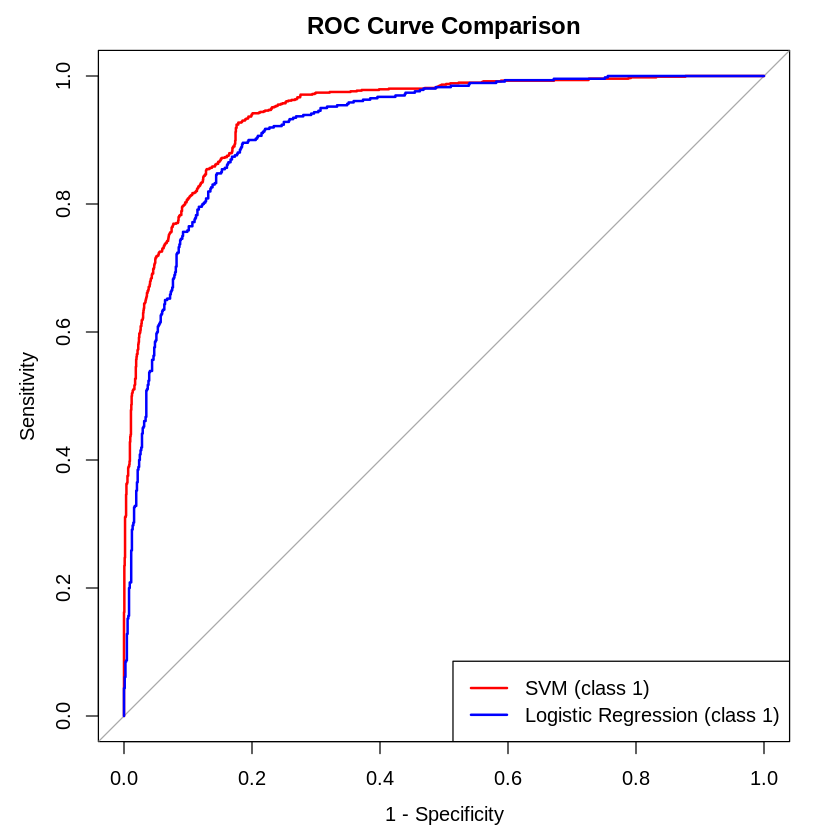

In [70]:
# SVM
plot.roc(svm_roc_list[[1]][[1]], col = "red", lwd = 2,
         main = "ROC Curve Comparison", legacy.axes = TRUE)

# Logistic Regression (LASSO)
plot.roc(roc_list[[1]], col = "blue", lwd = 2, add = TRUE)

legend("bottomright",
       legend = c("SVM (class 1)", "Logistic Regression (class 1)"),
       col = c("red", "blue"),
       lwd = 2)

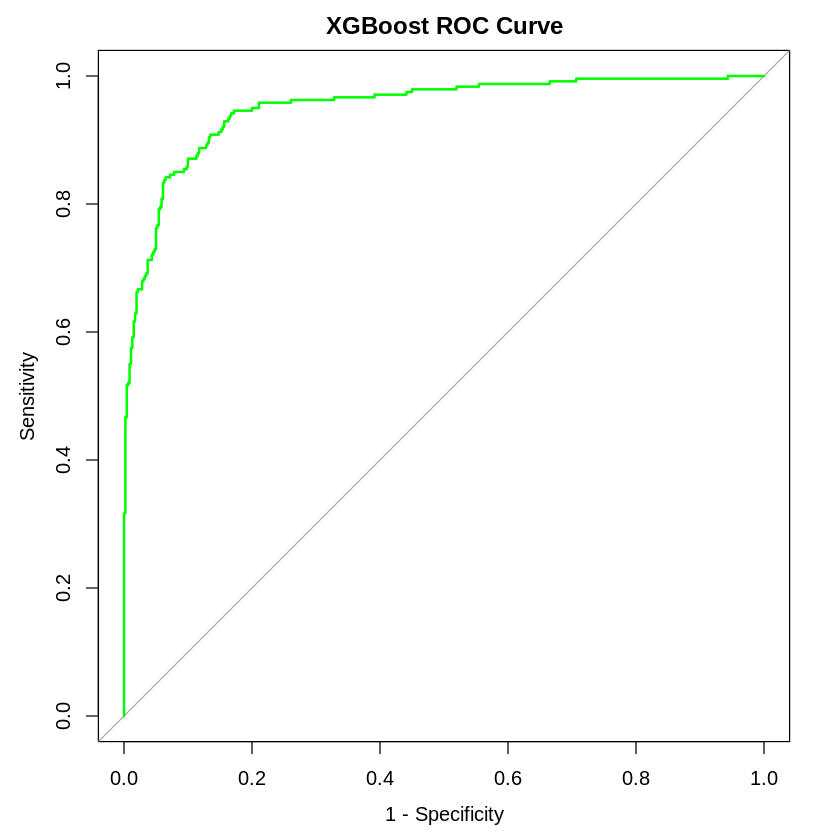

In [71]:
xgb_roc_list <- multi_roc_xgb$rocs
xgb_roc_plot <- xgb_roc_list[[1]][[1]]

plot.roc(xgb_roc_plot, col = "green", lwd = 2, main = "XGBoost ROC Curve", legacy.axes = TRUE)

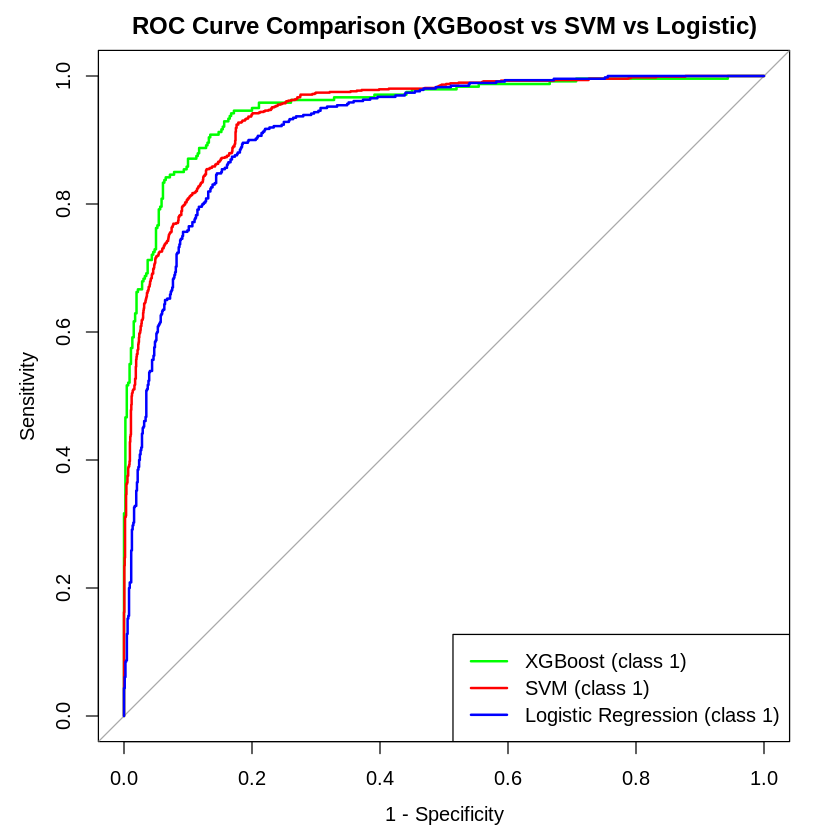

In [72]:
plot.roc(xgb_roc_plot,
         col = "green",
         lwd = 2,
         main = "ROC Curve Comparison (XGBoost vs SVM vs Logistic)",
         legacy.axes = TRUE)

plot.roc(svm_roc_list[[1]][[1]],
         col = "red",
         lwd = 2,
         add = TRUE)

plot.roc(roc_list[[1]],
         col = "blue",
         lwd = 2,
         add = TRUE)

legend("bottomright",
       legend = c("XGBoost (class 1)", "SVM (class 1)", "Logistic Regression (class 1)"),
       col = c("green", "red", "blue"),
       lwd = 2)

In [74]:
rf_results <- readRDS("/rf_results.rds")

In [79]:
rf_pred_probs <- rf_results$pred_probs
rf_true_labels <- rf_results$true_labels
rf_roc <- roc(rf_true_labels, rf_pred_probs[, 1])

Warning message in roc.default(rf_true_labels, rf_pred_probs[, 1]):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = admit, case = discharge

Setting direction: controls > cases



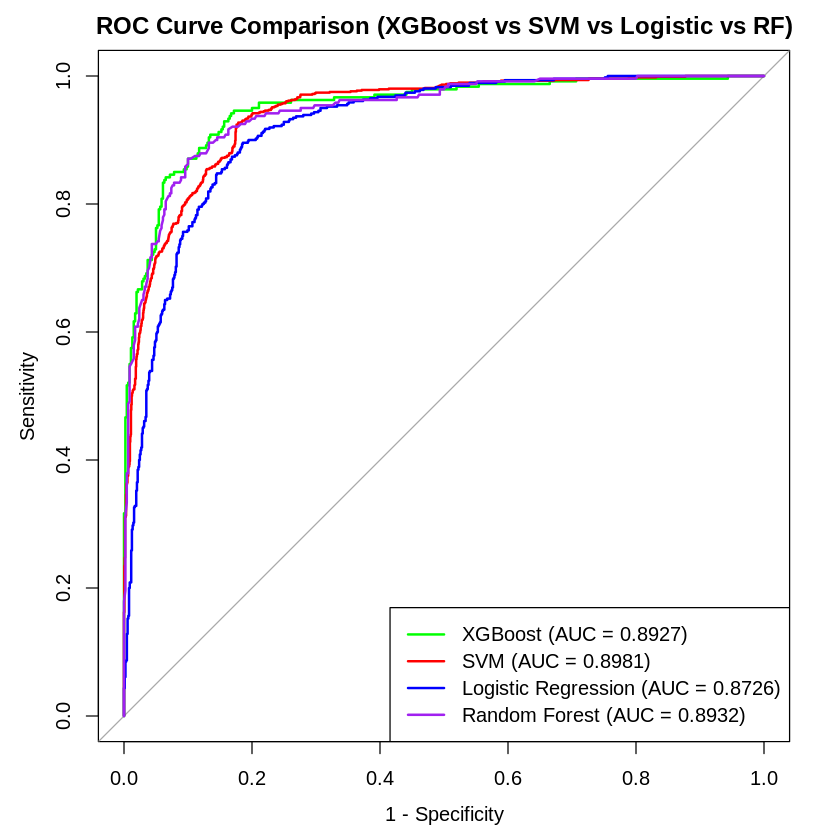

In [ ]:
# XGBoost
plot.roc(xgb_roc_plot,
         col = "green",
         lwd = 2,
         main = "ROC Curve Comparison (XGBoost vs SVM vs Logistic vs RF)",
         legacy.axes = TRUE)

# SVM
plot.roc(svm_roc_list[[1]][[1]],
         col = "red",
         lwd = 2,
         add = TRUE)

# Logistic
plot.roc(roc_list[[1]],
         col = "blue",
         lwd = 2,
         add = TRUE)

# Random Forest
plot.roc(rf_roc,
         col = "purple",
         lwd = 2,
         add = TRUE)

# legend
legend("bottomright",
       legend = c("XGBoost (AUC = 0.8927)", "SVM (AUC = 0.8981)", "Logistic Regression (AUC = 0.8726)", "Random Forest (AUC = 0.8932)"),
       col = c("green", "red", "blue", "purple"),
       lwd = 2)
